In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from itertools import combinations
import pickle
from tqdm import tqdm_notebook

In [3]:
alldata = pd.read_csv("/content/drive/MyDrive/base_alldata.csv")
data2 = pd.read_csv("/content/drive/MyDrive/data20000.csv")
with open ("/content/drive/MyDrive/data20000.pkl", "rb") as f:
    data = pickle.load(f)
data['A_label'] = data2['A_label']
data['B_label'] = data2['B_label']
data

,A_patent,B_patent,sam_label,A_label,B_label
0,"[0.36229375, -0.50979894, -0.071172826, 0.0716...","[0.59421617, -0.15761371, 0.07355781, -0.14865...",0,3,0
1,"[0.4170102, -0.1611865, 0.016234059, -0.034006...","[0.5061552, 0.09089776, 0.2494746, 0.46706584,...",1,6,6
2,"[0.21566992, 0.37108305, 0.581861, 0.4217709, ...","[-0.063228115, 0.20342293, -0.45882493, 0.0856...",0,3,4
3,"[0.17490184, 0.057280716, 0.33718467, 0.162178...","[0.60902894, -0.15597533, -0.1680133, -0.13122...",0,0,1
4,"[0.25884563, 0.13668944, -0.03792026, -0.06936...","[-0.076299764, -0.18286894, 0.44981137, -0.007...",0,5,0
...,...,...,...,...,...
23319,"[-0.11465991, -0.0045952667, -0.4231456, 0.127...","[0.17921987, -0.05672539, 0.11646745, -0.05281...",0,1,6
23320,"[0.3935649, -0.12443716, 0.05400295, 0.4531702...","[0.25731322, -0.21553199, 0.10416031, 0.032546...",0,0,1
23321,"[0.07053192, -0.25414056, -0.093417294, -0.129...","[0.36229375, -0.50979894, -0.071172826, 0.0716...",0,4,3
23322,"[0.25910273, -0.28315908, 0.12044519, 0.123281...","[0.30005488, -0.21446921, -0.67292786, 0.23480...",0,5,4


In [11]:
A_patent = data[['A_patent', 'A_label']]
A_patent = pd.DataFrame(A_patent.values, columns = ['patent', 'label'])
B_patent = data[['B_patent', 'B_label']]
B_patent = pd.DataFrame(B_patent.values, columns = ['patent', 'label'])
total_data = pd.concat([A_patent, B_patent])
total_data.index = range(len(total_data))
total_data

,patent,label
0,"[0.36229375, -0.50979894, -0.071172826, 0.0716...",3
1,"[0.4170102, -0.1611865, 0.016234059, -0.034006...",6
2,"[0.21566992, 0.37108305, 0.581861, 0.4217709, ...",3
3,"[0.17490184, 0.057280716, 0.33718467, 0.162178...",0
4,"[0.25884563, 0.13668944, -0.03792026, -0.06936...",5
...,...,...
46643,"[0.17921987, -0.05672539, 0.11646745, -0.05281...",6
46644,"[0.25731322, -0.21553199, 0.10416031, 0.032546...",1
46645,"[0.36229375, -0.50979894, -0.071172826, 0.0716...",3
46646,"[0.30005488, -0.21446921, -0.67292786, 0.23480...",4


In [15]:
# train_data = total_data[total_data['label'] < 4]
# test_data = total_data[total_data['label'] > 3]
# x_train = train_data['patent'].values
# y_train = train_data['label'].values.astype(np.int)
# x_test = test_data['patent'].values
# y_test = test_data['label'].values.astype(np.int)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(total_data['patent'].values, total_data['label'].values.astype(np.int), test_size=0.2, random_state=42)

x_train = np.vstack(x_train)
x_test = np.vstack(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [19]:
class patent_dataset(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.x = torch.FloatTensor(x_data)
        self.y = torch.tensor(y_data)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]



def generate_idx(batch_num):
    idx = []
    for i in range(batch_num):
        for j in range(batch_num):
            idx.append([i,j])
    idx = torch.tensor(idx).reshape(-1, 2)
    return idx

def generate_pair(data, label):
    batch_num = len(data)
    idx = generate_idx(batch_num)
    input1 = data[idx[:,0]]
    input2 = data[idx[:,1]]
    label = (label[idx[:,0]] == label[idx[:,1]]).type(torch.int)
    return input1, input2, label

In [20]:
batch_num = 64
train_dataset = patent_dataset(x_train, y_train)
test_dataset = patent_dataset(x_test, y_test)

In [21]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = batch_num)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle = True, batch_size = batch_num)

In [22]:
class fnn(nn.Module):
    def __init__(self):
        super(fnn, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64)
        )

    def forward(self, x1, x2):
        out1 = self.fc(x1)
        out2 = self.fc(x2)
        return out1, out2

In [23]:
def loss_fn(out1, out2, label, margin = 1):
    distance = torch.sum((out1 - out2)**2, 1)
    positive_loss = label*distance
    negative_loss = (1-label)*torch.clamp(margin - distance, min = 0)
    return torch.mean(positive_loss + negative_loss)

In [24]:
model = fnn().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 5*1e-4)

In [25]:
epochs = 50
train_loss_list = []
test_loss_list = []
for epoch in tqdm_notebook(range(1, epochs)):
    train_loss = 0
    model.train()
    for idx, (data, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        emb1, emb2, label = generate_pair(data, labels)
        out1, out2 = model(emb1.cuda(), emb2.cuda())
        loss = loss_fn(out1, out2, label.cuda())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss)

    model.eval()
    test_loss = 0
    for idx, (data, labels) in enumerate(test_dataloader):
        emb1, emb2, label = generate_pair(data, labels)
        out1, out2 = model(emb1.cuda(), emb2.cuda())
        loss = loss_fn(out1, out2, label.cuda())
        test_loss += loss.item()

    test_loss /= len(test_dataloader)
    test_loss_list.append(test_loss)

    print("Epoch : ", epoch, "Train loss : ", train_loss, "Test loss : ", test_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch :  1 Train loss :  0.03044275332021779 Test loss :  0.0002695010522099799
Epoch :  2 Train loss :  0.0009025099760860129 Test loss :  0.004865194209978903
Epoch :  3 Train loss :  0.000420230525995141 Test loss :  2.7394488451173943e-05
Epoch :  4 Train loss :  2.923763513349077e-05 Test loss :  0.00034552553382762773
Epoch :  5 Train loss :  0.001045723664957808 Test loss :  1.9146589095240192e-05
Epoch :  6 Train loss :  4.6646968993696046e-05 Test loss :  7.401327197902441e-06
Epoch :  7 Train loss :  4.898766125924252e-06 Test loss :  3.786414349135207e-06
Epoch :  8 Train loss :  0.0018111237356979565 Test loss :  0.00022418154409547554
Epoch :  9 Train loss :  4.3750521246088846e-05 Test loss :  1.3649994842076199e-05
Epoch :  10 Train loss :  1.4526606512172543e-05 Test loss :  5.676615065156461e-06
Epoch :  11 Train loss :  7.857314867516386e-06 Test loss :  3.202293918523176e-06
Epoch :  12 Train loss :  2.8894434470277877e-06 Test loss :  5.607939081291739e-06
Epoch :  

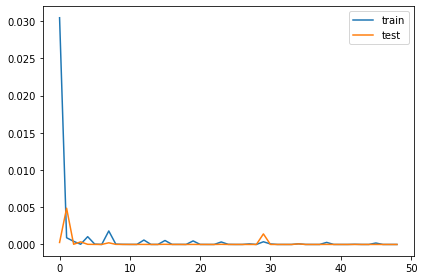

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label = "train")
plt.plot(test_loss_list, label = "test")
plt.legend(loc = "best")
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model, "/content/drive/MyDrive/patent_mode.pt")

In [27]:
total_out = []
total_labels = []
model.eval()
for idx, (data, labels) in enumerate(test_dataloader):
    out1, out2 = model(data.cuda(), torch.ones(1024).cuda())
    total_out.append(out1.cpu().detach())
    total_labels.append(labels)
total_out = torch.cat(total_out)
total_labels = torch.cat(total_labels)

In [28]:
labels.shape

torch.Size([50])

In [29]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
result = tsne.fit_transform(total_out.numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [31]:
total_labels

tensor([2, 1, 2,  ..., 2, 4, 3])

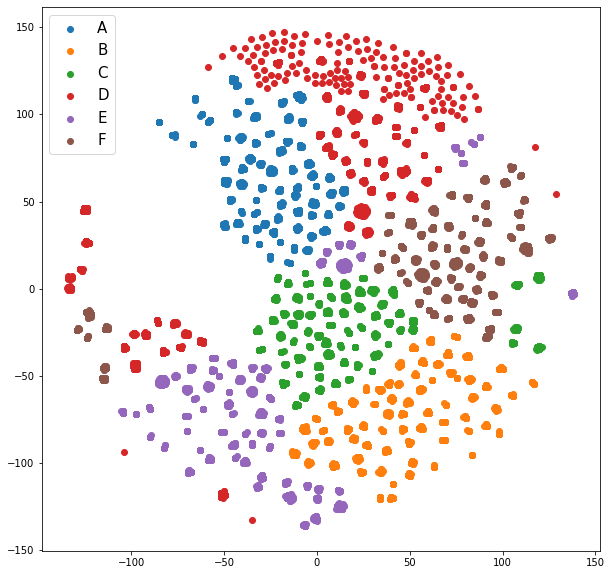

In [38]:
plt.figure(figsize = [10,10])
point_labels = ['A', 'B','C', 'D', 'E', 'F']
for i in range(6):
    idx = torch.where(total_labels == i)[0]
    plt.scatter(result[idx,0], result[idx,1], label = point_labels[i])

plt.legend(loc = "best", fontsize = 15)
plt.show()

In [ ]:
while True:pass

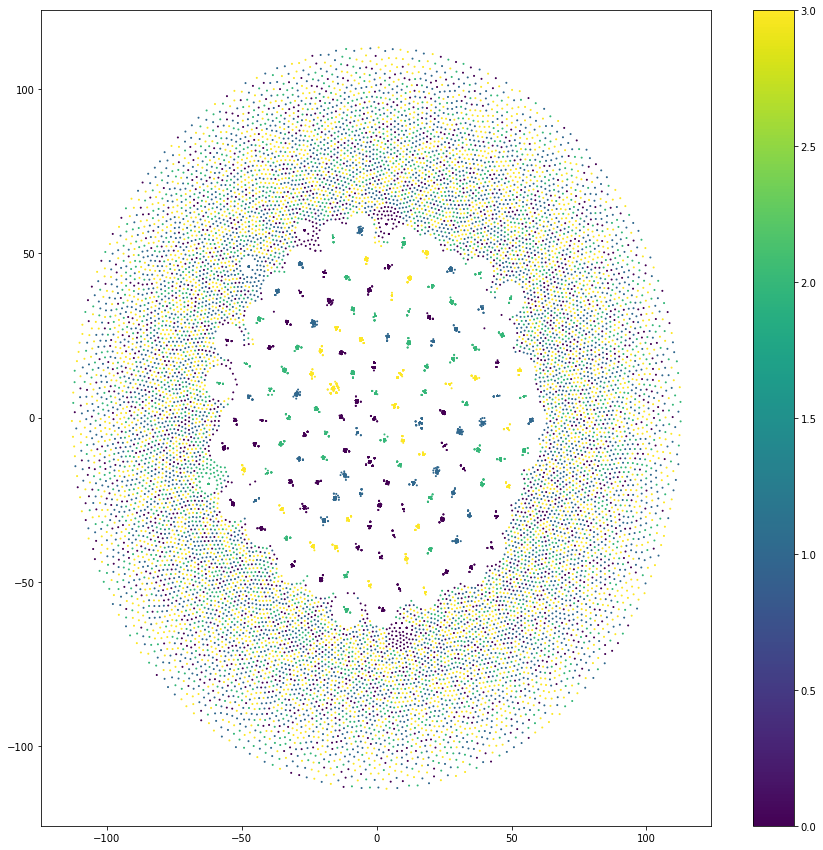

In [ ]:
plt.figure(figsize = [15,15])
plt.scatter(result[:,0], result[:,1],s = 1, c = total_labels)
plt.colorbar()
plt.show()

In [ ]:
result.shape

(19992, 2)

In [ ]:
while True:
    pass

KeyboardInterrupt: ignored